<img src="img/dsci572_header.png" width="600">

# Lecture 7: CNNs in Practice

<br><br><br>

## Lecture Learning Objectives


- Load image data using `torchvision.datasets.ImageFolder()` to train a network in PyTorch

- Explain what "data augmentation" is and why we might want to do it
- Be able to save and re-load a PyTorch model
- Tune the hyperparameters of a PyTorch model using [Ax](https://ax.dev/)
- Describe what transfer learning is and the different flavours of it: "out-of-the-box", "feature extractor", "fine tuning"

<br><br><br>

## Imports


In [1]:
import json
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, models, datasets
from torchsummary import summary
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from utils.plotting import *

In [2]:
from utils.set_seed import *

In [3]:
set_seed(1)

In [4]:
# !conda install -y memory_profiler

In [5]:
import memory_profiler

<br><br><br>

## Recap 


A Convolutional Neural Network (CNN) is a specialized type of neural network architecture predominantly used for image classification tasks. 

**The typical structure of a CNNs**  

- Several convolutional and pooling layers:
    - **Convolutional layers** (referred to as Conv2d layers in PyTorch) use filters or kernels to capture spatial hierarchies and patterns within the data.
    - **Activation functions** are employed to introduce non-linearities into the model.
    - **Pooling layers** are used to reduce the spatial dimensions of the feature maps, helping in decreasing the complexity of the model.
      
    - **Dropout layers (optional)** can be incorporated for regularization in order to prevent overfitting.
      
- Followed by a fully connected (dense) layer that leads to the output.
    - For binary classification: Use Sigmoid activation if using `BCELoss`
  
**Loss function**

- Multiclass classification: `CrossEntropyLoss`
- Binary classification: `BCEWithLogitsLoss` loss or use Sigmoid if using `BCELoss`
- For regression: No activation and MSELoss

**Parameters of the model and parameter sharing**
- The kernels (or filters) used in convolutional layers, along with their corresponding biases, and the weights (and biases) in the fully connected layers after flattening, constitute the parameters of the CNN model.
- CNNs use of the same convolutional filters across the entire input, allowing the network to detect features regardless of their spatial location and significantly reducing the number of parameters. This is known as **parameter sharing**. 

![](img/cnn_big_picture.png)

[Source](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

<br><br><br><br>

## 1. Datasets, Dataloaders, and Transforms


### 1.1 Preparing Data

- `torch` and `torchvision` provide out-of-the-box functionality for loading in lots of different kinds of data.

- The way you create a dataloader depends on the data you have (i.e., do you have numpy arrays, tensors, images, or something else?) and the PyTorch docs [can help you out](https://pytorch.org/docs/stable/data.html#dataset-types)
- Loading data into PyTorch is usually a two-step process:

    1. Create a `dataset` (this is your raw data)

    2. Create a `dataloader` (this will help you batch your data)
    
- Working with CNNs and images, you'll mostly be using `torchvision.datasets.ImageFolder()` ([docs](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)), it's very easy to use-

<br><br><br>

It assumes you have a directory structure with sub-directories for each class like this:

```
data
│
├── class_1
│   ├── image_1.png 
│   ├── image_2.png
│   ├── image_3.png
│   └── etc.
└── class_2
    ├── image_1.png 
    ├── image_2.png
    ├── image_3.png
    └── etc.
```

<br><br><br>

- For example, consider the training dataset I have in the current directory at `lectures/data/eva_bitmoji_rgb`:

```
eva_bitmoji_rgb
└── train
    ├── not_eva
    │   ├── image_1.png 
    │   ├── image_2.png
    │   ├── image_3.png
    │   └── etc.
    └── eva
        ├── image_1.png 
        ├── image_2.png
        ├── image_3.png
        └── etc.
```

In [6]:
TRAIN_DIR = "data/eva_bitmoji_rgb/train/"

mem = memory_profiler.memory_usage()[0]

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR)

print(f"Memory consumed: {memory_profiler.memory_usage()[0] - mem:.0f} MB")

Memory consumed: -1 MB


- Notice how our memory usage is the same, we aren't loading anything in yet, just making PyTorch aware of what kind of data we have and where it is

<br><br><br>

- We can now check various information about our `train_dataset`:

In [7]:
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
print(f"Samples:",len(train_dataset))
print(f"First sample: {train_dataset.samples[0]}")

Classes: ['eva', 'not_eva']
Class count: 1018, 1020
Samples: 2038
First sample: ('data/eva_bitmoji_rgb/train/eva/Eva_10039954 copy.png', 0)


- Now, we could start working with this dataset directly

- For example, here's the first sample:

In [8]:
gen = iter(train_dataset)

Class: eva


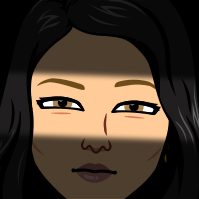

In [9]:
img, target = next(gen)
print(f"Class: {train_dataset.classes[target]}")
img

<br><br><br>

- But often we want to apply some **pre-processing** to our data

- For example, `ImageFolder` loads our data using the `PIL` package, but we need tensors

In [10]:
print(f"Image data type: {type(img)}")
print(f"     Image size: {img.size}")

Image data type: <class 'PIL.Image.Image'>
     Image size: (199, 199)


- Any pre-processing we wish to apply to our images is done using `torchvision.transforms`

- There are a lot of transformation options here, but we'll explore some more later. For now, we'll `Resize()` our images and convert them `ToTensor()`
- We use `transforms.Compose()` to chain multiple transformations together:

In [11]:
IMAGE_SIZE = (64, 64)

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)

img, target = next(iter(train_dataset))
print(f"Image data type: {type(img)}")
print(f"     Image size: {img.shape}")

Image data type: <class 'torch.Tensor'>
     Image size: torch.Size([3, 64, 64])


- Great, but there's one more issue: we want to work with **batches** of data, because most of the time, we won't be able to fit an entire dataset into RAM at once (especially when it comes to image data)

- This is where PyTorch's `dataloader` comes in
- It allows us to specify how we want to batch our data:

In [12]:
BATCH_SIZE = 64

mem = memory_profiler.memory_usage()[0]

train_loader = torch.utils.data.DataLoader(
    train_dataset,          # our raw data
    batch_size=BATCH_SIZE,  # the size of batches we want the dataloader to return
    shuffle=True,           # shuffle our data before batching
    drop_last=False         # don't drop the last batch even if it's smaller than batch_size
)

print(f"Memory consumed: {memory_profiler.memory_usage()[0] - mem:.0f} MB")

Memory consumed: 0 MB


- Once again, we aren't loading anything yet, we just prepared the loader

<br><br><br>

- We can now query the loader to return a batch of data (this will consume memory):

In [13]:
mem = memory_profiler.memory_usage()[0]

imgs, targets = next(iter(train_loader))

print(f"       # of batches: {len(train_loader)}")
print(f"    Image data type: {type(imgs)}")
print(f"   Image batch size: {imgs.shape}")  # dimensions are (batch size, image channels, image height, image width)
print(f"  Target batch size: {targets.shape}")
print(f"       Batch memory: {memory_profiler.memory_usage()[0] - mem:.2f} MB")  # memory usage after loading batch

       # of batches: 32
    Image data type: <class 'torch.Tensor'>
   Image batch size: torch.Size([64, 3, 64, 64])
  Target batch size: torch.Size([64])
       Batch memory: 7.46 MB


<br><br><br>

### 1.2 Saving and Loading PyTorch Models

- The [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) about saving and loading models is fantastic and the process is very easy

- It's common PyTorch convention to save models using either a `.pt` or `.pth` file extension

- It is recommended that you just save your model learned parameters from `model.state_dict()`:

```python
# Save model
PATH = "models/eva_cnn.pt"
torch.save(model.state_dict(), PATH)     # save model at PATH

# Load model
model = MyModelClass()                   # create an instance of the model
model.load_state_dict(torch.load(PATH))  # load model from PATH
```

<br><br><br>

- If you're using the model for **inference** (not training), make sure to switch it to eval mode: **`model.eval()`**

- There are other options for saving models, in particular, if you want to save a model and continue training it later, you'll want to save other necessary information like the optimizer state, the epoch you're on, etc. This is all documented here in the [PyTorch docs](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training).

- Let's see an example of a model I saved earlier:

In [14]:
class bitmoji_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 4, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3, 3)),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(324, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [15]:
PATH = "models/eva_cnn.pt"
model = bitmoji_CNN()
model.load_state_dict(torch.load(PATH))
model.eval()

bitmoji_CNN(
  (main): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=324, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
)

- **Saving the entire model** You can also save the entire model using `torch.save(model, filepath)`, which serializes the entire model object using Python's `pickle` module and saves it to a file. It includes not just the model's `state_dict` but also its class definition and all the hyperparameters.
- **Checkpointing during training**: For long-running training, you might want to save more than just the model's state_dict. Checkpoints typically include the model's state_dict, the optimizer's state_dict, and other variables like the current epoch number. 

<br><br><br>

### 1.3 Data Augmentation

- Data augmentation is used for two main purposes:

    1. Make your CNN more robust to certain variations in the dataset (e.g. scaling, rotation)

    2. Increase the size of your training set

<br><br><br>

- Let's explore point 1 a bit further. We can see below is a Bitmoji of Eva, does the CNN I loaded above predict this?

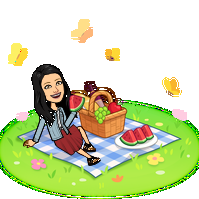

In [16]:
image = Image.open('img/test-examples/eva-picnic.png')
image

In [17]:
IMAGE_SIZE = (64, 64)

image_tensor = transforms.functional.to_tensor(image.resize(IMAGE_SIZE)).unsqueeze(0)
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)

print(f"Prediction: {train_dataset.classes[prediction]}")

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Prediction: eva


- But what happens if I flip my image? Can our CNN still correctly classify the image?

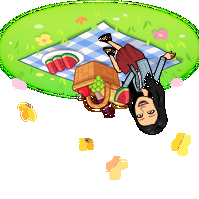

In [18]:
image_rotated = image.rotate(180)
image_rotated

In [19]:
image_tensor = transforms.functional.to_tensor(image_rotated.resize(IMAGE_SIZE)).unsqueeze(0)
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)

print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: not_eva


- This was just 1 example

- Let's see what happens if we vertically flip all images in our dataset, and then compute accuracy.

- Here's a helper function to compute accuracy:

In [20]:
def evaluate(model, valid_loader):
    """Validation wrapper for PyTorch network."""
    
    model.eval()
    accuracy = 0
    
    with torch.no_grad():
        for X, y in valid_loader:
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            accuracy += (y_hat_labels == y).type(torch.float32).mean().item()
    accuracy /= len(valid_loader)  # avg accuracy
    
    return accuracy

- Now let's feed the flipped version of the validation set to our model and compute accuracy:

In [21]:
TRAIN_DIR = "data/eva_bitmoji_rgb/train/"
VALID_DIR = "data/eva_bitmoji_rgb/valid/"
IMAGE_SIZE = (64, 64)


# Transforms
data_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),  # flip all images vertically
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

valid_dataset = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
BATCH_SIZE = len(valid_dataset)  # want to test on entire validation set
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

evaluate(model, valid_loader)

0.630859375

- The model has basically lost its predication capability, and that's problematic.

<br><br><br>

- We'd like our CNN to be robust against these kinds of differences

- We can expose our CNN to rotated images, so that it can learn to better predict them, with data augmentation

- Common image augmentations include:

    - rotation/flipping

    - cropping

    - adding noise
    
    - You can view others in the [PyTorch docs](https://pytorch.org/docs/stable/torchvision/transforms.html)

- We add transforms just like we did previously, using the `transform` argument of `torchvision.datasets.ImageFolder()`:

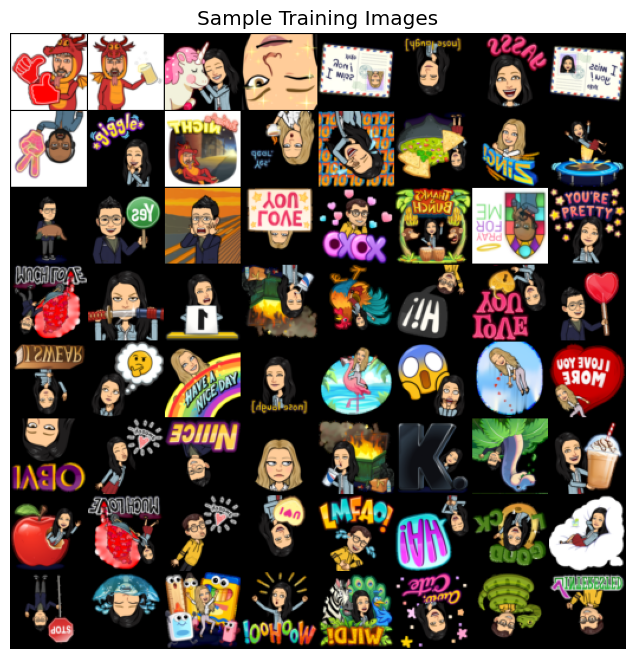

In [22]:
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_dataset_flipped = torchvision.datasets.ImageFolder(root=TRAIN_DIR,
                                                 transform=data_transforms)
train_loader_flipped = torch.utils.data.DataLoader(train_dataset_flipped,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=False)
sample_batch, target = next(iter(train_loader_flipped))

valid_dataset_flipped = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
BATCH_SIZE = len(valid_dataset)  # want to test on entire validation set
valid_loader_flipped = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

plot_bitmojis(sample_batch, rgb=True)

- Here's a model I trained earlier using **augmented** data using the following transformations:

```python
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
```


In [23]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # SOLUTION
device

device(type='mps')

In [24]:
# PATH = "models/eva_cnn_augmented.pt"
# torch.save(model_augmented.state_dict(), PATH)     # save model at PATH

- Note that I've only used vertical and horizontal flipping of the images, instead of rotating by other angles. In the latter case, I would have had to somehow deal with the empty areas of the rotated images (appearing as black areas around the rotated images above).

In [25]:
PATH = "models/eva_cnn_augmented.pt"
model = bitmoji_CNN()
model.load_state_dict(torch.load(PATH))
model.eval();

- Let's try it out on the flipped image:

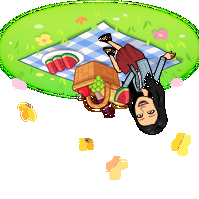

In [26]:
image_rotated

In [27]:
image_tensor = transforms.functional.to_tensor(image_rotated.resize(IMAGE_SIZE)).unsqueeze(0)
prediction = int(torch.sigmoid(model(image_tensor)) > 0.5)
print(f"Prediction: {train_dataset.classes[prediction]}")

Prediction: eva


- Looking good. Let's once again compute accuracy for the flipped version of the validation set:

In [28]:
evaluate(model, valid_loader)

0.880859375

- This time, the CNN trained with augmented dataset demonstrates similar performance on the rotated version of the bitmojis.

<br><br><br>

### 1.4 (Optional) Batch Normalization 

- Earlier in the course, we saw how normalizing the inputs to our neural network can help our optimization (by making sure the scale of one feature doesn't overwhelm others)

- But what about the hidden layers of our network? They also have data flowing into them and parameters to optimize, can we normalize them too to make optimization better?

- Batch normalization is the normalization of data in hidden layers

- It is usually applied before (and sometimes after) the activation function of a hidden layer:

$$z^* = \frac{z - \mu}{\sqrt{\sigma^2 + \eta}}\times \gamma + \beta$$

- Where:

    - $z$ = the output of your hidden layers before/after the activation function

    - $\mu = \frac{1}{n}\sum_{i=1}^{n}z_i$ (i.e., the mean of $z$)

    - $\sigma^2 = \frac{1}{n}\sum_{i=1}^{n}(z_i-\mu)^2$ (i.e, the variance of $z$)
    
    - $\gamma$ and $\beta$ are parameters that are learned through backpropagation

- Batch normalization can help stabilize and speed up optimization, make your network more invariant to changes in the training distribution, and often has a slight regularization effect

- Even though we have some guiding intuitions about the mechanics of batch normalization, we still don't have a widely accepted theory for how _exactly_ this technique works the way it does
  - "_Somewhat shockingly, however, despite its prominence, we still have a poor understanding of what the effectiveness of BatchNorm is stemming from._" ([Santurkar et al., 2018](https://arxiv.org/abs/1805.11604))
  
  - Read more about this issue [here](https://www.d2l.ai/chapter_convolutional-modern/batch-norm.html#discussion)

<br><br><br>

## 2. Hyperparameter Tuning

- With neural networks we potentially have a lot of hyperparameters to tune:

    - Number of layers

    - Number of nodes in each layer
    - Activation functions
    - Regularization
    - Initialization (starting weights)
    - Optimization hyperparameters (learning rate, momentum, weight decay)
    - etc.

- When the number of hyperparameters are large and models are expensive to compute, brute force strategies such as **grid search** perform poorly. In these cases, we need to make our approach smarter. For example, we can use an optimization algorithm instead of blindly evaluating our model for all values of hyperparameters.

- There are many packages out there that make neural network hyperparameter tuning fast and easy using such approaches

  - [Ax](https://ax.dev/)
  
  - [Raytune](https://docs.ray.io/en/latest/tune/index.html)
  - [Neptune](https://neptune.ai/)
  - [skorch](https://skorch.readthedocs.io/en/stable/index.html)
  
- We'll be using [Ax](https://ax.dev/), created by Facebook (just like PyTorch)

- Ax uses Bayesian optimization to tune the hyperparameters of our model (how? see [here](https://ax.dev/docs/bayesopt.html#how-does-it-work))

<br><br><br>

In [29]:
# !conda install -y ax-platform

- Below, I've adapted a tutorial from [their docs](https://ax.dev/tutorials/tune_cnn.html):

In [30]:
from ax.service.managed_loop import optimize
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import train, evaluate

- First, I'll create some simple training and validation loaders:

In [31]:
TRAIN_DIR = "data/eva_bitmoji_rgb/train/"
VALID_DIR = "data/eva_bitmoji_rgb/valid/"
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 128

# Transforms
data_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

# Load data and create dataloaders
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# GPU available?
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using: {device}")

# Model
model = bitmoji_CNN()
model.to(device);

Using: mps


- Now, we need a training function

- This function will be re-run multiple times throughout the hyperparameter optimization process, as we wish to train the model on different hyperparameter configurations

- The argument `hyperparameters` is a dictionary containing the hyperparameters we wish to tune:

In [32]:
def train(model, train_loader, hyperparameters, epochs=10):
    """Training wrapper for PyTorch network."""

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=hyperparameters.get("lr", 0.001),
                           betas=(hyperparameters.get("beta1", 0.9), 0.999))
    
    for epoch in range(epochs):
        for X, y in train_loader:
            if device.type in ['cuda', 'mps']:
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
    
    return model

- We also need an `evaluate()` function that reports how well our model is doing on some validation data

- This will also be called multiple times during the hyperparameter optimization

- We have already defined such a function before in this lecture, but here is its definition again:

In [33]:
def evaluate(model, valid_loader):
    """Validation wrapper for PyTorch network."""
    
    model.eval()
    accuracy = 0
    
    with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
        for X, y in valid_loader:
            if device.type in ['cuda', 'mps']:
                X, y = X.to(device), y.to(device)
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            accuracy += (y_hat_labels == y).type(torch.float32).mean().item()
    accuracy /= len(valid_loader)  # avg accuracy
    
    return accuracy    

- Let's make sure our evaluation function is working:

In [34]:
evaluate(model, valid_loader)

0.47265625

- The accuracy is bad right now because we haven't trained our model yet

- We then have a wrapper function that puts everything together

- Basically each iteration of hyperparameter optimization (i.e., each time we try a new set of hyperparameters), this function is executed. It trains the model using the given hyperparameters, and then evaluates the model's performance.

In [35]:
def train_evaluate(parameterization):
    model = bitmoji_CNN()
    model.to(device)
    model = train(model, train_loader, hyperparameters=parameterization)
    return evaluate(model, valid_loader)

- Finally, we use `optimize()` to run Bayesian optimization on a hyperparameter dictionary

- I ran this on a GPU and have included the output below:

In [37]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True, "value_type": 'float'},
        {"name": "beta1", "type": "range", "bounds": [0.2, 0.999], "value_type": 'float'},
    ],
    evaluation_function=train_evaluate,
    objective_name='accuracy',
    total_trials = 20
)

```
[INFO 01-28 17:25:27] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 01-28 17:25:27] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 01-28 17:25:27] ax.service.managed_loop: Running optimization trial 1...
[INFO 01-28 17:26:28] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-28 17:27:25] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-28 17:28:20] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-28 17:29:13] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-28 17:30:06] ax.service.managed_loop: Running optimization trial 6...
[INFO 01-28 17:31:01] ax.service.managed_loop: Running optimization trial 7...
[INFO 01-28 17:31:57] ax.service.managed_loop: Running optimization trial 8...
[INFO 01-28 17:32:52] ax.service.managed_loop: Running optimization trial 9...
[INFO 01-28 17:33:46] ax.service.managed_loop: Running optimization trial 10...
[INFO 01-28 17:34:41] ax.service.managed_loop: Running optimization trial 11...
[INFO 01-28 17:35:36] ax.service.managed_loop: Running optimization trial 12...
[INFO 01-28 17:36:30] ax.service.managed_loop: Running optimization trial 13...
[INFO 01-28 17:37:25] ax.service.managed_loop: Running optimization trial 14...
[INFO 01-28 17:38:20] ax.service.managed_loop: Running optimization trial 15...
[INFO 01-28 17:39:15] ax.service.managed_loop: Running optimization trial 16...
[INFO 01-28 17:40:08] ax.service.managed_loop: Running optimization trial 17...
[INFO 01-28 17:41:03] ax.service.managed_loop: Running optimization trial 18...
[INFO 01-28 17:41:59] ax.service.managed_loop: Running optimization trial 19...
[INFO 01-28 17:43:01] ax.service.managed_loop: Running optimization trial 20...
```

In [ ]:
best_parameters

```python
{'lr': 0.0015762617170424081, 'beta1': 0.6464455205729447}
```

In [ ]:
means, covariances = values
print(f"Accuracy: {means['accuracy'] * 100:.2f}%")

```python
Accuracy: 86.91%
```

In [ ]:
render(plot_contour(model=model, param_x='lr', param_y='beta1', metric_name='accuracy'))

<img src="img/hyperparam-tuning.png" width="800">

In [ ]:
best_objectives = np.array(
    [[trial.objective_mean * 100 for trial in experiment.trials.values()]]
)
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

<img src="img/hyperparam-tuning-2.png" width="600">

<br><br><br>

## 3. (Optional) Explaining CNNs 


- CNNs and neural networks in general are primarily used for **prediction** (i.e., we want the best prediction performance, and we might not care how we get it)

- However interpreting why a model makes certain predictions can be useful

- Interpreting neural networks is an active area of research and it is difficult to do

- There are a few main options:

    - [SHAP](https://shap.readthedocs.io/en/latest/image_examples.html)

    - [Grad-CAM](https://github.com/jacobgil/pytorch-grad-cam)
    
    - [Captum](https://github.com/pytorch/captum)

- Captum is a library for specifically interpreting PyTorch models. It's quite new still but has some great functionality!

- Captum contains a variety of state-of-the-art algorithms for interpreting model predictions, see the [docs here](https://captum.ai/docs/attribution_algorithms)

In [38]:
# !conda install -y captum

<br><br><br>

## 4. Transfer Learning


- In practice, very few people train an entire CNN from scratch because it requires a large dataset, powerful computers, and a huge amount of human effort to train the model.

- Instead, a common practice is to download a pre-trained model and fine tune it for your task. This is called **transfer learning**.

- Transfer learning is one of the most common techniques used in the context of computer vision and natural language processing.

- It refers to using a model already trained on one task as a starting point for learning to perform another task

- There are many famous deep learning architectures out there that have been very successful across a wide range of problems, e.g.: [AlexNet](https://arxiv.org/abs/1404.5997), [VGG](https://arxiv.org/abs/1409.1556), [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/abs/1512.00567), [MobileNet](https://arxiv.org/abs/1801.04381), etc.

- Many of these models have been pre-trained on famous datasets like ImageNet [[1](https://www.image-net.org/index.php), [2](https://en.wikipedia.org/wiki/ImageNet)]


**[ImageNet](https://www.image-net.org/about.php)**

- [ImageNet](http://www.image-net.org/) is an image dataset that became a very popular benchmark in the field ~10 years ago. 

- Currently contains ~14 million labelled images with ~21,841 categories
  
- There are various versions with different number of images and classes
    - ILSVRC, a popular annual competition in computer vision, uses a smaller subset of ImageNet. This subset consists of about 1.2 million training images, 50,000 validation images, and 150,000 testing images across 1,000 categories. 

- [Wikipedia article](https://en.wikipedia.org/wiki/ImageNet) on ImageNet
- Here are some example classes. 

In [39]:
with open("data/imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]
classes[100:110]

['black swan, Cygnus atratus',
 'tusker',
 'echidna, spiny anteater, anteater',
 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 'wallaby, brush kangaroo',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'wombat',
 'jellyfish',
 'sea anemone, anemone',
 'brain coral']

- The idea of transfer learning is instead of developing a machine learning model from scratch, you use these available pre-trained models for your tasks either directly or by fine tuning them. 
- There are three common ways to use transfer learning in computer vision 
    1. Using pre-trained models out-of-the-box 
    2. Using pre-trained models as feature extractor and training your own model with these features
    2. Starting with weights of pre-trained models and fine-tuning the weights for your task. 
- We will explore the first two approaches.     

<br><br>

### 4.1 Using pre-trained models out-of-the-box 

- Let's first try one of these models and apply it to our own problem right out of the box

![](img/cnn-ex.png)

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

- We can easily download famous models using the `torchvision.models` module. All models are available with pre-trained weights (based on ImageNet's 224 x 224 images)

- Remember this example I showed you in the intro video of DSCI 571?
    - We used a pre-trained model vgg16 which is trained on the ImageNet data. 
    - We preprocess the given image. 
    - We get prediction from this pre-trained model on a given image along with prediction probabilities.  
    - For a given image, this model will spit out one of the 1000 classes from ImageNet. 

In [40]:
def classify_image(img, topn = 4):
    clf = vgg16(weights='VGG16_Weights.DEFAULT') # initialize the classifier with VGG16 weights
    preprocess = transforms.Compose([
                 transforms.Resize(299),
                 transforms.CenterCrop(299),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225]),])

    with open('data/imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]
    
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)
    clf.eval()
    output = clf(batch_t)
    _, indices = torch.sort(output, descending=True)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    d = {'Class': [classes[idx] for idx in indices[0][:topn]], 
         'Probability score': [np.round(probabilities[0, idx].item(),3) for idx in indices[0][:topn]]}
    df = pd.DataFrame(d, columns = ['Class','Probability score'])
    return df

In [41]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16

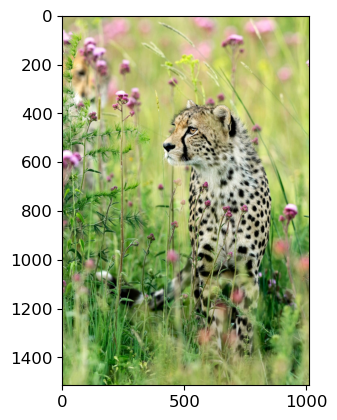

                                     Class  Probability score
         cheetah, chetah, Acinonyx jubatus              0.983
                  leopard, Panthera pardus              0.012
jaguar, panther, Panthera onca, Felis onca              0.004
       snow leopard, ounce, Panthera uncia              0.001
--------------------------------------------------------------


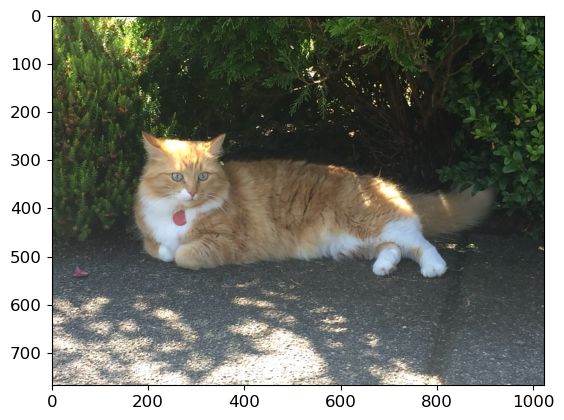

                         Class  Probability score
                     tiger cat              0.353
              tabby, tabby cat              0.207
               lynx, catamount              0.050
Pembroke, Pembroke Welsh corgi              0.046
--------------------------------------------------------------


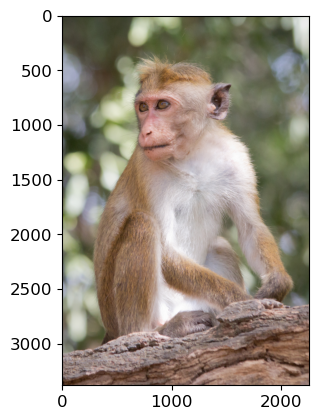

                                   Class  Probability score
                                 macaque              0.714
patas, hussar monkey, Erythrocebus patas              0.122
      proboscis monkey, Nasalis larvatus              0.098
                   guenon, guenon monkey              0.017
--------------------------------------------------------------


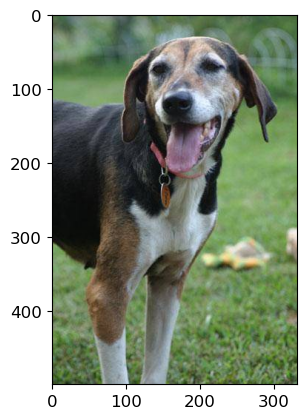

                        Class  Probability score
Walker hound, Walker foxhound              0.580
             English foxhound              0.091
                  EntleBucher              0.080
                       beagle              0.065
--------------------------------------------------------------


In [42]:
# Predict labels with associated probabilities for unseen images
import glob
images = glob.glob("img/test_img/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- We got these predictions without "doing the ML ourselves".
  
- We are using **pre-trained** `vgg16` model which is available in `torchvision`.
  
- `torchvision` has many such pre-trained models available that have been very successful across a wide range of tasks: AlexNet, VGG, ResNet, Inception, MobileNet, etc.
- Many of these models have been pre-trained on famous datasets like **ImageNet**. 
- So if we use them out-of-the-box, they will give us one of the ImageNet classes as classification. 

Let's try it out on some very different from the training set. 

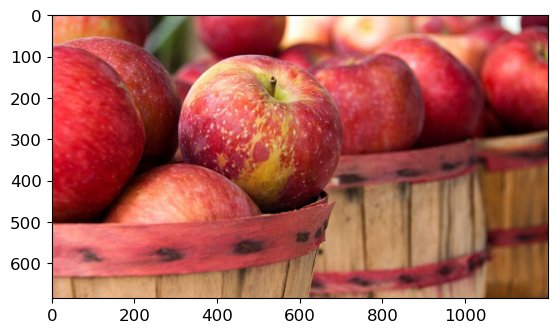

                                      Class  Probability score
                                        fig              0.637
                                pomegranate              0.193
grocery store, grocery, food market, market              0.041
                                      crate              0.023
--------------------------------------------------------------


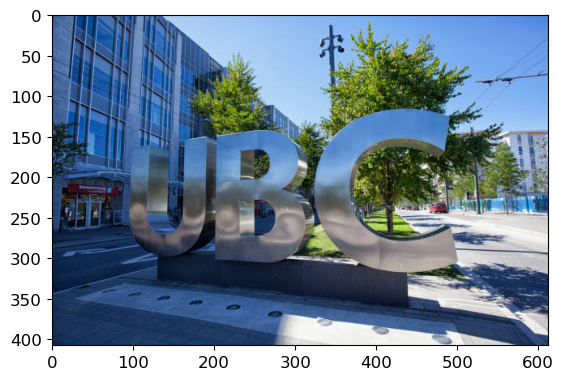

                                               Class  Probability score
                                         toilet seat              0.171
                                          safety pin              0.060
bannister, banister, balustrade, balusters, handrail              0.039
                                              bubble              0.035
--------------------------------------------------------------


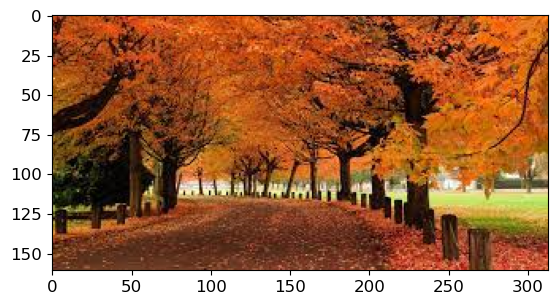

                                                    Class  Probability score
worm fence, snake fence, snake-rail fence, Virginia fence              0.202
                                                     barn              0.036
                                                   sorrel              0.033
                                             valley, vale              0.029
--------------------------------------------------------------


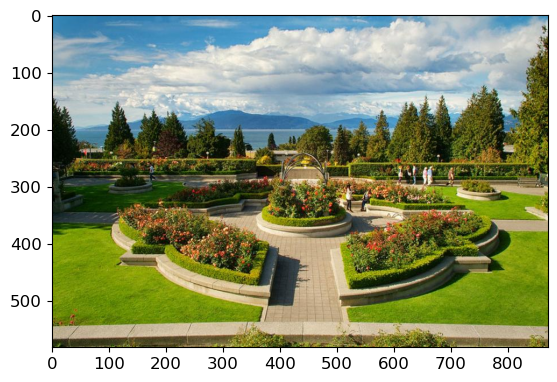

              Class  Probability score
     patio, terrace              0.213
           fountain              0.164
lakeside, lakeshore              0.097
            sundial              0.088
--------------------------------------------------------------


In [43]:
# Predict labels with associated probabilities for unseen images
images = glob.glob("img/UBC_img/*.*")
for image in images:
    img = Image.open(image)
    img.load()
    plt.imshow(img)
    plt.show()
    df = classify_image(img)
    print(df.to_string(index=False))
    print("--------------------------------------------------------------")

- It's not doing very well here because ImageNet don't have proper classes for these images.
  
- Here we are using pre-trained models out-of-the-box. 
- Can we use pre-trained models for our own classification problem with our classes? 
- Yes!! There are two ways to benefit from transfer learning:

    1. Use a pre-trained network as a "**feature extractor**" and add new layers to it for your own task

    2. Same as the previous one, but also "**fine-tune**" the weights of the pre-trained network using your own data

<br><br><br>

### 4.2 Using pre-trained models as feature extractors

- In this method, we use a pre-trained model as a "feature extractor" which creates useful features for us that we can use to train some other model

- We have two options here:

    1. Add some extra layers to the pre-trained network to suit our particular task

    2. Pass training data through the network and save the output to use as features for training some other model

<br><br><br>

### 4.2.1 Approach 1: Adding extra layers to the pre-trained network 

- Let's do approach 1 first. Let's adapt `DenseNet` to predict our bitmoji data. I'm going to load the model, and then "freeze" all of its parameters (we don't want to update them)

**(Optional)**

- [DenseNet paper](https://arxiv.org/pdf/1608.06993.pdf)
- This architecture connects each layer to every other layer in a feed-forward fashion.
- The dense connectivity ensures maximum information flow between layers in the network. This connectivity leads to significant improvements in efficiency and effectiveness in learning, as each layer has access to all preceding layers' feature maps. 
![](img/densenet.png)

In [44]:
densenet = models.densenet121(weights='DenseNet121_Weights.DEFAULT')

for param in densenet.parameters():  # Freeze parameters so we don't update them
    param.requires_grad = False

- The layers can be accessed using the `.named_children()` method, the last one is the classification layer, a fully-connected layer outputting 1000 values (one for each ImageNet class):

In [45]:
list(densenet.named_children())[-1]

('classifier', Linear(in_features=1024, out_features=1000, bias=True))

In [46]:
densenet.classifier

Linear(in_features=1024, out_features=1000, bias=True)

- We are going to do binary classification, so let's replace this layer with our own layers:

In [47]:
new_layers = nn.Sequential(
    nn.Linear(1024, 500),
    nn.ReLU(),
    nn.Linear(500, 1)
)
densenet.classifier = new_layers

- Let's check that the last layer of our model is updated:

In [48]:
densenet.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=1, bias=True)
)

- Now we need to train our new layers:

In [49]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

# New dataloaders
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [50]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type in ['cuda', 'mps']:
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type in ['cuda', 'mps']:
                    X, y = X.to(device), y.to(device)
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}

In [51]:
# We have a big model so this will take some time to run! If you have a GPU, things could be much faster!
densenet.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, train_loader, valid_loader, device, epochs=10)

Epoch 1: Train Accuracy: 0.59 Valid Accuracy: 0.66
Epoch 2: Train Accuracy: 0.73 Valid Accuracy: 0.70
Epoch 3: Train Accuracy: 0.76 Valid Accuracy: 0.71
Epoch 4: Train Accuracy: 0.80 Valid Accuracy: 0.71
Epoch 5: Train Accuracy: 0.82 Valid Accuracy: 0.74
Epoch 6: Train Accuracy: 0.83 Valid Accuracy: 0.75
Epoch 7: Train Accuracy: 0.84 Valid Accuracy: 0.76
Epoch 8: Train Accuracy: 0.87 Valid Accuracy: 0.76
Epoch 9: Train Accuracy: 0.87 Valid Accuracy: 0.74
Epoch 10: Train Accuracy: 0.88 Valid Accuracy: 0.78


```C
Epoch 1: Train Accuracy: 0.68 Valid Accuracy: 0.72
Epoch 2: Train Accuracy: 0.77 Valid Accuracy: 0.71
Epoch 3: Train Accuracy: 0.80 Valid Accuracy: 0.73
Epoch 4: Train Accuracy: 0.86 Valid Accuracy: 0.78
Epoch 5: Train Accuracy: 0.89 Valid Accuracy: 0.81
Epoch 6: Train Accuracy: 0.90 Valid Accuracy: 0.81
Epoch 7: Train Accuracy: 0.90 Valid Accuracy: 0.80
Epoch 8: Train Accuracy: 0.94 Valid Accuracy: 0.84
Epoch 9: Train Accuracy: 0.95 Valid Accuracy: 0.85
Epoch 10: Train Accuracy: 0.96 Valid Accuracy: 0.84
```

- We leveraged the power of `DenseNet` to get a good model, **without training any convolutional layers ourselves**.

<br><br><br>

### 4.2.2 Approach 2: Using extracted features in other models
- Now, you can use pre-trained model as arbitrary feature extractors, you don't have to add on layers, you can just extract the output values of the network (well, you can extract values from any layer you like) and use those values as "features" to train another model

- Below, I'm going to pass all my bitmoji data through the network and save the outputs:

In [52]:
def get_features(model, train_loader, valid_loader):
    """
    Extract features from both training and validation datasets using the provided model.

    This function passes data through a given neural network model to extract features. It's designed 
    to work with datasets loaded using PyTorch's DataLoader. The function operates under the assumption 
    that gradients are not required, optimizing memory and computation for inference tasks.
    """

    # Disable gradient computation for efficiency during inference
    with torch.no_grad():
        # Initialize empty tensors for training features and labels
        Z_train = torch.empty((0, 1024))  # Assuming each feature vector has 1024 elements
        y_train = torch.empty((0))

        # Initialize empty tensors for validation features and labels
        Z_valid = torch.empty((0, 1024))
        y_valid = torch.empty((0))

        # Process training data
        for X, y in train_loader:
            # Extract features and concatenate them to the corresponding tensors
            Z_train = torch.cat((Z_train, model(X)), dim=0) 
            y_train = torch.cat((y_train, y))

        # Process validation data
        for X, y in valid_loader:
            # Extract features and concatenate them to the corresponding tensors
            Z_valid = torch.cat((Z_valid, model(X)), dim=0)
            y_valid = torch.cat((y_valid, y))

    # Return the feature and label tensors
    return Z_train, y_train, Z_valid, y_valid


In [53]:
densenet = models.densenet121(weights='DenseNet121_Weights.DEFAULT')
densenet.classifier = nn.Identity()  # remove that last "classification" layer
Z_train, y_train, Z_valid, y_valid = get_features(densenet, train_loader, valid_loader)

In [54]:
Z_train.shape

torch.Size([2038, 1024])

- Now we have some extracted features

- Let's train a classifier on the data, say, a `LogisticRegression()` model:

In [55]:
# Let's scale our data
scaler = StandardScaler()
Z_train = scaler.fit_transform(Z_train)
Z_valid = scaler.transform(Z_valid)

# Fit a model
model = LogisticRegression(max_iter=1000)
model.fit(Z_train, y_train)

print(f"Train accuracy: {model.score(Z_train, y_train) * 100:.2f}%")
print(f"Valid accuracy: {model.score(Z_valid, y_valid) * 100:.2f}%")

Train accuracy: 100.00%
Valid accuracy: 79.49%


- So what did we just do:

  1. We passed out bitmoji images through DenseNet and saved all the output values. DenseNet outputs 1024 values per input. We had 2038 bitmoji images, so we extracted a tensor of shape `(2038, 1024)` from DenseNet.
  
  2. We now have a dataset of 1024 features and 2038 examples for a binary classification problem
  
  3. We used this data to train a logistic regression model.

<br><br><br>

### 4.3 Using pre-trained models for fine tuning

- Alright, this is the final and most common workflow of transfer learning

- Above, we stacked some extra layers onto `DenseNet` and just trained those layer (we "froze" all of `DenseNet`'s weights)

- But we can also "fine tune" `DenseNet`'s weights if we like, to make it more suited to our data

- We can choose to "fine tune" all of `DenseNet`'s ~8 million parameters, or just some of them

- To do this, we use the same workflow as above, but we unfreeze the layers we wish to "fine-tune"

In [56]:
# Load (but don't freeze) the model
densenet = models.densenet121(weights='DenseNet121_Weights.DEFAULT')

# Replace classification layer
new_layers = nn.Sequential(
    nn.Linear(1024, 500),
    nn.ReLU(),
    nn.Linear(500, 1)
)

densenet.classifier = new_layers

# Move to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

densenet.to(device);

In [57]:
# Train the model
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, train_loader, valid_loader, device, epochs=3)

Epoch 1: Train Accuracy: 0.82 Valid Accuracy: 0.83
Epoch 2: Train Accuracy: 0.93 Valid Accuracy: 0.84
Epoch 3: Train Accuracy: 0.96 Valid Accuracy: 0.95


```C
Epoch 1: Train Accuracy: 0.79 Valid Accuracy: 0.61
Epoch 2: Train Accuracy: 0.95 Valid Accuracy: 0.97
Epoch 3: Train Accuracy: 0.98 Valid Accuracy: 0.98
```

- By far our best results yet

- You could also choose to fine-tune just some layers. For example, below I'll freeze everything but the last two layers:

In [58]:
# Freeze all but the last two layers
for layer in densenet.features[:-2]:
    for param in layer.parameters():
        param.requires_grad = False
        
# Now re-train...

- Fine-tuning more layers typically leads to better accuracy, but we have to pay the cost of training.

<br><br><br>

### 4.4 Transfer Learning Summary

1. Use a pre-trained model as a "feature extractor" (good if you want to adapt a pre-trained model for a specific problem)

2. Fine-tune a pre-trained model (same as 2 but generally yields better results, although at more computational cost)

<br><br><br>

## 5. Lecture Highlights


1. PyTorch makes data loading easy with `dataset` and `dataloader`.

2. Hyperparameter tuning is hard. Don't do grid-search when the cost of computations is very high. Use smarter methods such as [Ax](https://ax.dev/).
3. Transfer learning is a very powerful method to adapt successful models and datasets to your own problem.